# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

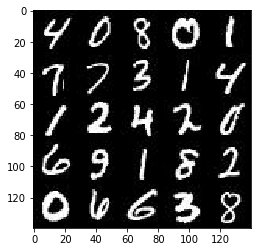

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

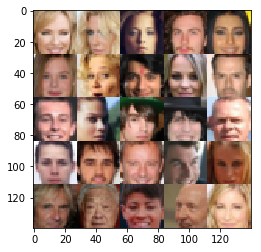

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, None)
    return input_images, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/edward/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/edward/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/edward/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/edward/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/edward/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/edward/anaconda3/lib/python3.6/site-packages/zmq/eventloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.05
    drop_out = 0.5
    kernel_initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('discriminator', reuse = reuse):
            conv1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same', kernel_initializer=kernel_initializer)
            relu1 = tf.maximum(alpha * conv1, conv1)
            
            conv2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same', kernel_initializer=kernel_initializer)
            norm2 = tf.layers.batch_normalization(conv2, training=True)
            relu2 = tf.maximum(alpha * norm2, norm2)
            dropout2 = tf.nn.dropout(relu2, keep_prob=drop_out)

            conv3 = tf.layers.conv2d(dropout2, 256, 3, strides=1, padding='same', kernel_initializer=kernel_initializer)
            norm3 = tf.layers.batch_normalization(conv3, training=True)
            relu3 = tf.maximum(alpha * norm3, norm3)
            dropout3 = tf.nn.dropout(relu3, keep_prob=drop_out)

            # Flatten it
            flat = tf.contrib.layers.flatten(dropout3)           
            logits = tf.layers.dense(flat, 1)
            output = tf.sigmoid(logits)
        
    return output, logits

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.05
    drop_out = 0.5
    kernel_initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('generator', reuse=not is_train):
 
        dense1 = tf.reshape( tf.layers.dense(z, 28*28*64), (-1, 7, 7, 1024) )
        norm1 = tf.layers.batch_normalization(dense1, training=is_train)
        relu1 = tf.maximum(alpha * norm1, norm1)
        
        conv2 = tf.layers.conv2d_transpose(relu1, 512, 3, strides=2, padding='same', kernel_initializer=kernel_initializer)
        norm2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha * norm2, norm2)
        dropout2 = tf.nn.dropout(relu2, keep_prob = drop_out)
        
        conv3 = tf.layers.conv2d_transpose(dropout2, 256, 3, strides=2, padding='same', kernel_initializer=kernel_initializer)
        norm3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.maximum(alpha * norm3, norm3)
        dropout3 = tf.nn.dropout(relu3, keep_prob = drop_out)
        
        conv4 = tf.layers.conv2d(dropout3, 128, 3, strides=1, padding='same', kernel_initializer=kernel_initializer)
        norm4 = tf.layers.batch_normalization(conv4, training=is_train)
        relu4 = tf.maximum(alpha * norm4, norm4)
        dropout4 = tf.nn.dropout(relu4, keep_prob = drop_out) 
        
        # Output layer 
        logits = tf.layers.conv2d(dropout4, out_channel_dim, 3, strides=1, padding='same', kernel_initializer=kernel_initializer)
        output = tf.tanh(logits)
            
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    d_model_real, d_logits_real = discriminator(input_real)
    g_model = generator(input_z, out_channel_dim)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)   
    
    d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth))
    
    d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    
    g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    
    return (tf.reduce_mean(d_loss_real+d_loss_fake), tf.reduce_mean(g_loss))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vairables = tf.trainable_variables()
    dis_vars = [var for var in train_vairables if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vairables if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        opt_dis_var = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        opt_gen_var = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return opt_dis_var, opt_gen_var


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    if (data_image_mode == "RGB"):
        out_channel_dim = 3
    else:
        out_channel_dim = 1
            
    input_images, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)                                                                                                                 
    dis_loss, gen_loss = model_loss(input_images, input_z, out_channel_dim)       
    dis_opt, gen_opt = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0      
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # Sample random noises
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_images *= 2
                feed_dict={input_images: batch_images, input_z: batch_z, lr: learning_rate}
                
                sess.run([gen_loss, gen_opt], feed_dict=feed_dict)
                
                gen_train_loss, _ = sess.run([gen_loss, gen_opt], feed_dict=feed_dict) 
                dis_train_loss, _ = sess.run([dis_loss, dis_opt], feed_dict=feed_dict)
                    
                if steps % 20 == 0:
#                     dis_train_loss = dis_loss.eval(feed_dict=feed_dict)
#                     gen_train_loss = gen_loss.eval({input_z: batch_z})
                    
                    print("Step: {}, Epoch: {}/{}...".format(steps, (epoch_i+1), epoch_count),
                          "Discriminator Loss: {:.4f}".format(dis_train_loss),
                          "Generator Loss: {:.4f}".format(gen_train_loss))
                
                if steps % 100 == 0:                    
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                                                        
                steps += 1 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step: 0, Epoch: 1/2... Discriminator Loss: 2.0589 Generator Loss: 1.6962


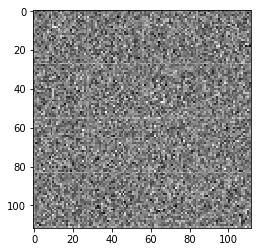

Step: 20, Epoch: 1/2... Discriminator Loss: 1.5188 Generator Loss: 1.2497
Step: 40, Epoch: 1/2... Discriminator Loss: 1.5176 Generator Loss: 1.2275
Step: 60, Epoch: 1/2... Discriminator Loss: 1.4152 Generator Loss: 1.6558
Step: 80, Epoch: 1/2... Discriminator Loss: 1.3597 Generator Loss: 1.5742
Step: 100, Epoch: 1/2... Discriminator Loss: 1.6573 Generator Loss: 1.0513


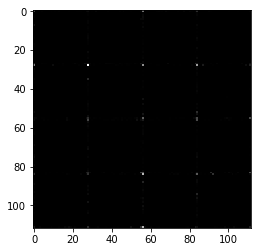

Step: 120, Epoch: 1/2... Discriminator Loss: 1.2552 Generator Loss: 1.3346
Step: 140, Epoch: 1/2... Discriminator Loss: 1.1300 Generator Loss: 1.7107
Step: 160, Epoch: 1/2... Discriminator Loss: 1.2232 Generator Loss: 1.6538
Step: 180, Epoch: 1/2... Discriminator Loss: 1.2788 Generator Loss: 1.5887
Step: 200, Epoch: 1/2... Discriminator Loss: 1.2361 Generator Loss: 1.1172


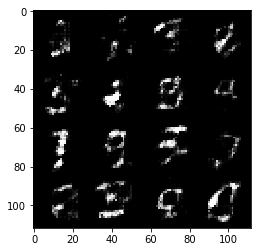

Step: 220, Epoch: 1/2... Discriminator Loss: 1.6789 Generator Loss: 2.2196
Step: 240, Epoch: 1/2... Discriminator Loss: 1.4435 Generator Loss: 1.8027
Step: 260, Epoch: 1/2... Discriminator Loss: 1.3576 Generator Loss: 1.1362
Step: 280, Epoch: 1/2... Discriminator Loss: 1.4407 Generator Loss: 1.9022
Step: 300, Epoch: 1/2... Discriminator Loss: 1.3707 Generator Loss: 1.3590


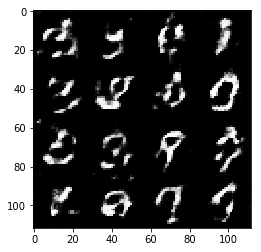

Step: 320, Epoch: 1/2... Discriminator Loss: 1.3204 Generator Loss: 1.3312
Step: 340, Epoch: 1/2... Discriminator Loss: 1.5846 Generator Loss: 1.2298
Step: 360, Epoch: 1/2... Discriminator Loss: 1.4059 Generator Loss: 1.0714
Step: 380, Epoch: 1/2... Discriminator Loss: 1.6250 Generator Loss: 1.8443
Step: 400, Epoch: 1/2... Discriminator Loss: 1.1801 Generator Loss: 1.0929


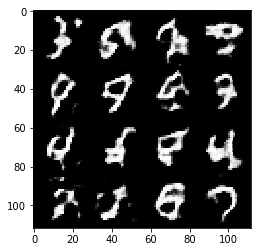

Step: 420, Epoch: 1/2... Discriminator Loss: 1.2683 Generator Loss: 1.0064
Step: 440, Epoch: 1/2... Discriminator Loss: 1.3138 Generator Loss: 0.8791
Step: 460, Epoch: 1/2... Discriminator Loss: 1.1855 Generator Loss: 1.3212
Step: 480, Epoch: 1/2... Discriminator Loss: 1.2982 Generator Loss: 1.1409
Step: 500, Epoch: 1/2... Discriminator Loss: 1.2022 Generator Loss: 1.2239


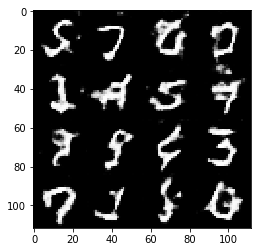

Step: 520, Epoch: 1/2... Discriminator Loss: 1.3241 Generator Loss: 1.1191
Step: 540, Epoch: 1/2... Discriminator Loss: 1.4489 Generator Loss: 1.0672
Step: 560, Epoch: 1/2... Discriminator Loss: 1.2642 Generator Loss: 1.4061
Step: 580, Epoch: 1/2... Discriminator Loss: 1.3215 Generator Loss: 1.1688
Step: 600, Epoch: 1/2... Discriminator Loss: 1.1828 Generator Loss: 1.2928


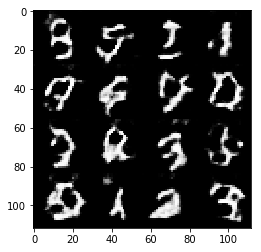

Step: 620, Epoch: 1/2... Discriminator Loss: 1.4519 Generator Loss: 0.6774
Step: 640, Epoch: 1/2... Discriminator Loss: 1.4866 Generator Loss: 1.4049
Step: 660, Epoch: 1/2... Discriminator Loss: 1.2495 Generator Loss: 1.0973
Step: 680, Epoch: 1/2... Discriminator Loss: 1.2791 Generator Loss: 1.1148
Step: 700, Epoch: 1/2... Discriminator Loss: 1.3038 Generator Loss: 1.1008


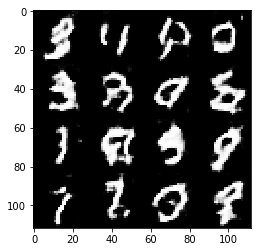

Step: 720, Epoch: 1/2... Discriminator Loss: 1.4404 Generator Loss: 1.3489
Step: 740, Epoch: 1/2... Discriminator Loss: 1.2640 Generator Loss: 1.3126
Step: 760, Epoch: 1/2... Discriminator Loss: 1.3936 Generator Loss: 0.9453
Step: 780, Epoch: 1/2... Discriminator Loss: 1.3107 Generator Loss: 1.0258
Step: 800, Epoch: 1/2... Discriminator Loss: 1.1624 Generator Loss: 1.3076


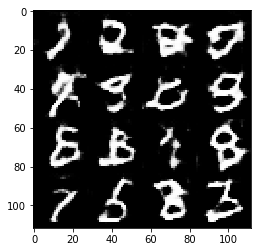

Step: 820, Epoch: 1/2... Discriminator Loss: 1.3775 Generator Loss: 1.3843
Step: 840, Epoch: 1/2... Discriminator Loss: 1.3727 Generator Loss: 1.2151
Step: 860, Epoch: 1/2... Discriminator Loss: 1.3753 Generator Loss: 1.4055
Step: 880, Epoch: 1/2... Discriminator Loss: 1.2119 Generator Loss: 0.9506
Step: 900, Epoch: 1/2... Discriminator Loss: 1.2264 Generator Loss: 1.0946


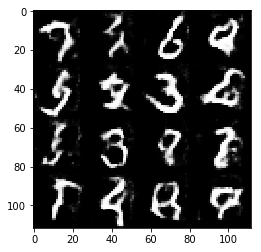

Step: 920, Epoch: 1/2... Discriminator Loss: 1.2282 Generator Loss: 1.0909
Step: 940, Epoch: 2/2... Discriminator Loss: 1.3503 Generator Loss: 0.9526
Step: 960, Epoch: 2/2... Discriminator Loss: 1.3621 Generator Loss: 1.1581
Step: 980, Epoch: 2/2... Discriminator Loss: 1.3151 Generator Loss: 1.0938
Step: 1000, Epoch: 2/2... Discriminator Loss: 1.3274 Generator Loss: 0.9336


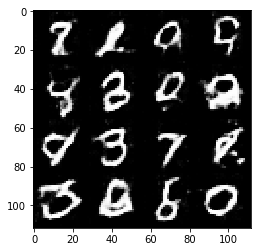

Step: 1020, Epoch: 2/2... Discriminator Loss: 1.4305 Generator Loss: 1.4544
Step: 1040, Epoch: 2/2... Discriminator Loss: 1.3222 Generator Loss: 1.2908
Step: 1060, Epoch: 2/2... Discriminator Loss: 1.3629 Generator Loss: 1.1144
Step: 1080, Epoch: 2/2... Discriminator Loss: 1.2944 Generator Loss: 1.1858
Step: 1100, Epoch: 2/2... Discriminator Loss: 1.4163 Generator Loss: 1.0239


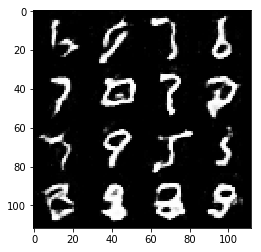

Step: 1120, Epoch: 2/2... Discriminator Loss: 1.3555 Generator Loss: 1.1297
Step: 1140, Epoch: 2/2... Discriminator Loss: 1.4479 Generator Loss: 0.9298
Step: 1160, Epoch: 2/2... Discriminator Loss: 1.3807 Generator Loss: 1.2894
Step: 1180, Epoch: 2/2... Discriminator Loss: 1.4577 Generator Loss: 0.8663
Step: 1200, Epoch: 2/2... Discriminator Loss: 1.2660 Generator Loss: 0.8871


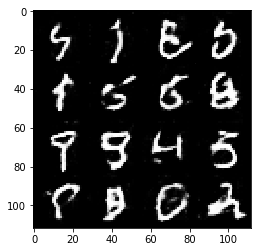

Step: 1220, Epoch: 2/2... Discriminator Loss: 1.3838 Generator Loss: 0.9986
Step: 1240, Epoch: 2/2... Discriminator Loss: 1.4310 Generator Loss: 1.2838
Step: 1260, Epoch: 2/2... Discriminator Loss: 1.4361 Generator Loss: 1.0409
Step: 1280, Epoch: 2/2... Discriminator Loss: 1.2681 Generator Loss: 1.1656
Step: 1300, Epoch: 2/2... Discriminator Loss: 1.4438 Generator Loss: 1.0256


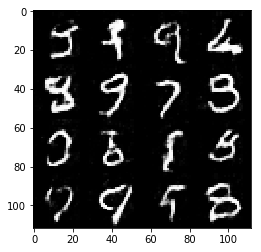

Step: 1320, Epoch: 2/2... Discriminator Loss: 1.4723 Generator Loss: 1.0979
Step: 1340, Epoch: 2/2... Discriminator Loss: 1.3721 Generator Loss: 0.9906
Step: 1360, Epoch: 2/2... Discriminator Loss: 1.4148 Generator Loss: 0.7966
Step: 1380, Epoch: 2/2... Discriminator Loss: 1.3207 Generator Loss: 0.9618
Step: 1400, Epoch: 2/2... Discriminator Loss: 1.2436 Generator Loss: 0.9829


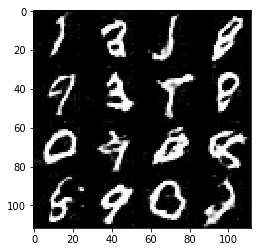

Step: 1420, Epoch: 2/2... Discriminator Loss: 1.4133 Generator Loss: 1.1962
Step: 1440, Epoch: 2/2... Discriminator Loss: 1.2732 Generator Loss: 1.1105
Step: 1460, Epoch: 2/2... Discriminator Loss: 1.3320 Generator Loss: 1.3243
Step: 1480, Epoch: 2/2... Discriminator Loss: 1.4685 Generator Loss: 0.9896
Step: 1500, Epoch: 2/2... Discriminator Loss: 1.2951 Generator Loss: 0.9523


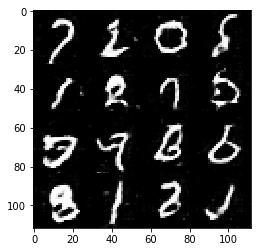

Step: 1520, Epoch: 2/2... Discriminator Loss: 1.4359 Generator Loss: 1.1350
Step: 1540, Epoch: 2/2... Discriminator Loss: 1.2997 Generator Loss: 1.1244
Step: 1560, Epoch: 2/2... Discriminator Loss: 1.4739 Generator Loss: 0.9076
Step: 1580, Epoch: 2/2... Discriminator Loss: 1.3599 Generator Loss: 0.9745
Step: 1600, Epoch: 2/2... Discriminator Loss: 1.3720 Generator Loss: 1.1494


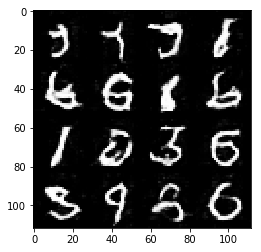

Step: 1620, Epoch: 2/2... Discriminator Loss: 1.3806 Generator Loss: 1.0656
Step: 1640, Epoch: 2/2... Discriminator Loss: 1.4065 Generator Loss: 1.0857
Step: 1660, Epoch: 2/2... Discriminator Loss: 1.3982 Generator Loss: 1.1770
Step: 1680, Epoch: 2/2... Discriminator Loss: 1.5271 Generator Loss: 1.4174
Step: 1700, Epoch: 2/2... Discriminator Loss: 1.4557 Generator Loss: 0.8249


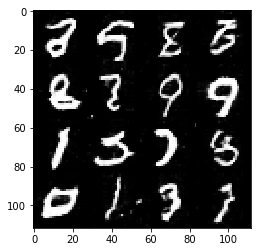

Step: 1720, Epoch: 2/2... Discriminator Loss: 1.3971 Generator Loss: 0.9224
Step: 1740, Epoch: 2/2... Discriminator Loss: 1.4474 Generator Loss: 1.0404
Step: 1760, Epoch: 2/2... Discriminator Loss: 1.3992 Generator Loss: 0.9381
Step: 1780, Epoch: 2/2... Discriminator Loss: 1.3642 Generator Loss: 1.0957
Step: 1800, Epoch: 2/2... Discriminator Loss: 1.3314 Generator Loss: 0.9252


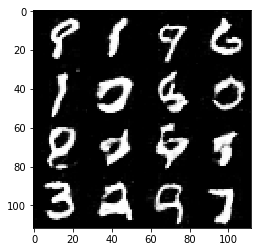

Step: 1820, Epoch: 2/2... Discriminator Loss: 1.2670 Generator Loss: 1.0235
Step: 1840, Epoch: 2/2... Discriminator Loss: 1.3360 Generator Loss: 0.9837
Step: 1860, Epoch: 2/2... Discriminator Loss: 1.4175 Generator Loss: 0.8486


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step: 0, Epoch: 1/1... Discriminator Loss: 1.9159 Generator Loss: 0.5758


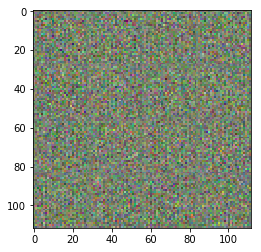

Step: 20, Epoch: 1/1... Discriminator Loss: 0.7297 Generator Loss: 2.6619
Step: 40, Epoch: 1/1... Discriminator Loss: 0.8068 Generator Loss: 2.7903
Step: 60, Epoch: 1/1... Discriminator Loss: 0.6758 Generator Loss: 3.5100
Step: 80, Epoch: 1/1... Discriminator Loss: 0.6595 Generator Loss: 3.6303
Step: 100, Epoch: 1/1... Discriminator Loss: 0.7391 Generator Loss: 3.5257


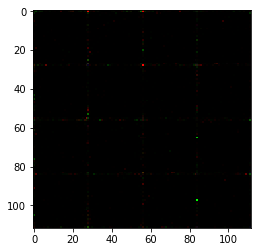

Step: 120, Epoch: 1/1... Discriminator Loss: 0.5631 Generator Loss: 3.8086
Step: 140, Epoch: 1/1... Discriminator Loss: 0.5706 Generator Loss: 2.8362
Step: 160, Epoch: 1/1... Discriminator Loss: 0.8233 Generator Loss: 2.7111
Step: 180, Epoch: 1/1... Discriminator Loss: 0.8735 Generator Loss: 2.5546
Step: 200, Epoch: 1/1... Discriminator Loss: 0.9158 Generator Loss: 2.5606


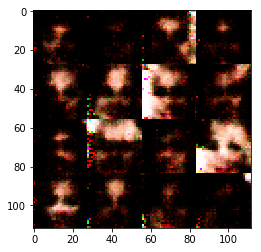

Step: 220, Epoch: 1/1... Discriminator Loss: 0.8089 Generator Loss: 2.8196
Step: 240, Epoch: 1/1... Discriminator Loss: 0.8359 Generator Loss: 2.5211
Step: 260, Epoch: 1/1... Discriminator Loss: 0.8711 Generator Loss: 2.9225
Step: 280, Epoch: 1/1... Discriminator Loss: 1.1312 Generator Loss: 3.0555
Step: 300, Epoch: 1/1... Discriminator Loss: 1.2814 Generator Loss: 1.8444


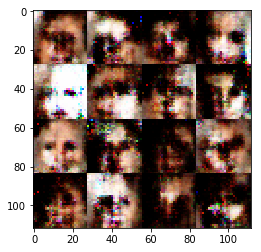

Step: 320, Epoch: 1/1... Discriminator Loss: 1.2922 Generator Loss: 1.6326
Step: 340, Epoch: 1/1... Discriminator Loss: 1.4808 Generator Loss: 1.2631
Step: 360, Epoch: 1/1... Discriminator Loss: 1.2270 Generator Loss: 1.3805
Step: 380, Epoch: 1/1... Discriminator Loss: 1.0672 Generator Loss: 1.6970
Step: 400, Epoch: 1/1... Discriminator Loss: 1.4706 Generator Loss: 1.5890


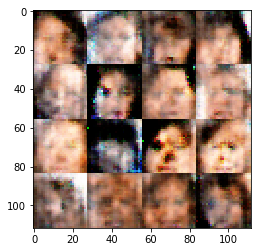

Step: 420, Epoch: 1/1... Discriminator Loss: 1.4768 Generator Loss: 1.4657
Step: 440, Epoch: 1/1... Discriminator Loss: 1.3517 Generator Loss: 1.3266
Step: 460, Epoch: 1/1... Discriminator Loss: 1.4292 Generator Loss: 1.4934
Step: 480, Epoch: 1/1... Discriminator Loss: 1.6822 Generator Loss: 1.4603
Step: 500, Epoch: 1/1... Discriminator Loss: 1.4585 Generator Loss: 1.5912


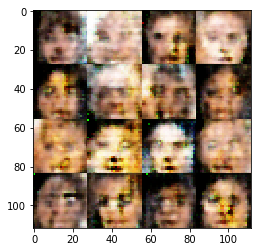

Step: 520, Epoch: 1/1... Discriminator Loss: 1.5672 Generator Loss: 1.6314
Step: 540, Epoch: 1/1... Discriminator Loss: 1.3300 Generator Loss: 1.2865
Step: 560, Epoch: 1/1... Discriminator Loss: 1.3234 Generator Loss: 1.4594
Step: 580, Epoch: 1/1... Discriminator Loss: 1.3033 Generator Loss: 1.1274
Step: 600, Epoch: 1/1... Discriminator Loss: 1.3737 Generator Loss: 1.1974


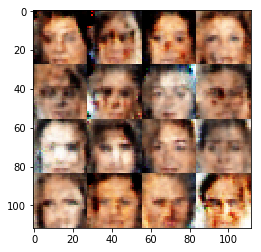

Step: 620, Epoch: 1/1... Discriminator Loss: 1.5004 Generator Loss: 1.3038
Step: 640, Epoch: 1/1... Discriminator Loss: 1.3933 Generator Loss: 1.2900
Step: 660, Epoch: 1/1... Discriminator Loss: 1.3530 Generator Loss: 1.2832
Step: 680, Epoch: 1/1... Discriminator Loss: 1.5280 Generator Loss: 1.3804
Step: 700, Epoch: 1/1... Discriminator Loss: 1.3943 Generator Loss: 1.1829


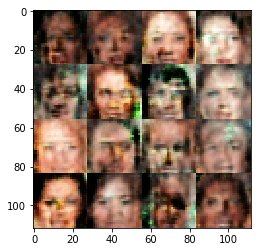

Step: 720, Epoch: 1/1... Discriminator Loss: 1.4837 Generator Loss: 0.9047
Step: 740, Epoch: 1/1... Discriminator Loss: 1.4553 Generator Loss: 1.1411
Step: 760, Epoch: 1/1... Discriminator Loss: 1.5237 Generator Loss: 1.0273
Step: 780, Epoch: 1/1... Discriminator Loss: 1.4097 Generator Loss: 1.3477
Step: 800, Epoch: 1/1... Discriminator Loss: 1.4724 Generator Loss: 1.0145


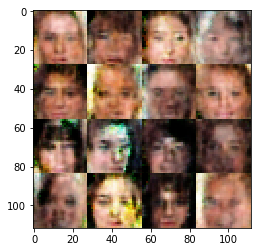

Step: 820, Epoch: 1/1... Discriminator Loss: 1.3860 Generator Loss: 0.9544
Step: 840, Epoch: 1/1... Discriminator Loss: 1.3729 Generator Loss: 0.8749
Step: 860, Epoch: 1/1... Discriminator Loss: 1.5097 Generator Loss: 0.9610
Step: 880, Epoch: 1/1... Discriminator Loss: 1.4638 Generator Loss: 1.1902
Step: 900, Epoch: 1/1... Discriminator Loss: 1.4973 Generator Loss: 1.0195


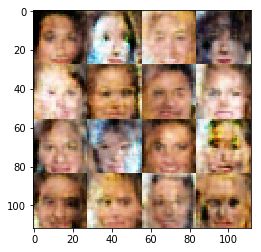

Step: 920, Epoch: 1/1... Discriminator Loss: 1.5572 Generator Loss: 1.2363
Step: 940, Epoch: 1/1... Discriminator Loss: 1.2762 Generator Loss: 1.3577
Step: 960, Epoch: 1/1... Discriminator Loss: 1.4420 Generator Loss: 1.1662
Step: 980, Epoch: 1/1... Discriminator Loss: 1.4844 Generator Loss: 1.1156
Step: 1000, Epoch: 1/1... Discriminator Loss: 1.5298 Generator Loss: 1.3239


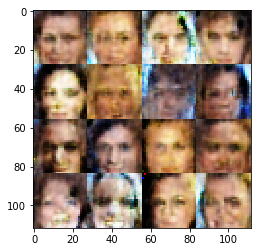

Step: 1020, Epoch: 1/1... Discriminator Loss: 1.5524 Generator Loss: 1.0497
Step: 1040, Epoch: 1/1... Discriminator Loss: 1.6267 Generator Loss: 0.9911
Step: 1060, Epoch: 1/1... Discriminator Loss: 1.6675 Generator Loss: 1.3397
Step: 1080, Epoch: 1/1... Discriminator Loss: 1.4059 Generator Loss: 1.1058
Step: 1100, Epoch: 1/1... Discriminator Loss: 1.4919 Generator Loss: 1.2464


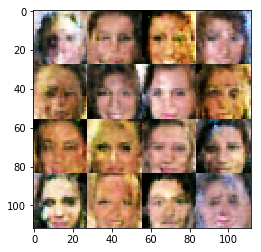

Step: 1120, Epoch: 1/1... Discriminator Loss: 1.5407 Generator Loss: 0.6848
Step: 1140, Epoch: 1/1... Discriminator Loss: 1.4862 Generator Loss: 1.1403
Step: 1160, Epoch: 1/1... Discriminator Loss: 1.4431 Generator Loss: 1.1858
Step: 1180, Epoch: 1/1... Discriminator Loss: 1.4369 Generator Loss: 0.9078
Step: 1200, Epoch: 1/1... Discriminator Loss: 1.3886 Generator Loss: 1.1081


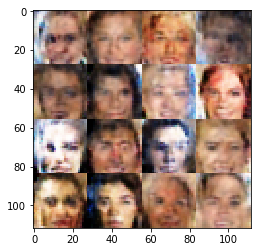

Step: 1220, Epoch: 1/1... Discriminator Loss: 1.4554 Generator Loss: 0.9513
Step: 1240, Epoch: 1/1... Discriminator Loss: 1.5021 Generator Loss: 0.9670
Step: 1260, Epoch: 1/1... Discriminator Loss: 1.3244 Generator Loss: 1.1551
Step: 1280, Epoch: 1/1... Discriminator Loss: 1.3924 Generator Loss: 1.0455
Step: 1300, Epoch: 1/1... Discriminator Loss: 1.4605 Generator Loss: 0.9051


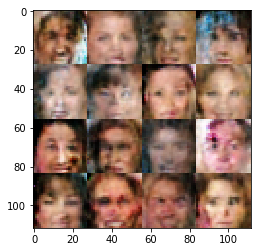

Step: 1320, Epoch: 1/1... Discriminator Loss: 1.4370 Generator Loss: 0.9083
Step: 1340, Epoch: 1/1... Discriminator Loss: 1.4901 Generator Loss: 0.8433
Step: 1360, Epoch: 1/1... Discriminator Loss: 1.4277 Generator Loss: 1.1775
Step: 1380, Epoch: 1/1... Discriminator Loss: 1.4107 Generator Loss: 0.8604
Step: 1400, Epoch: 1/1... Discriminator Loss: 1.4678 Generator Loss: 0.9772


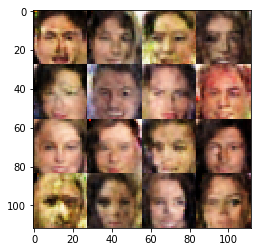

Step: 1420, Epoch: 1/1... Discriminator Loss: 1.4083 Generator Loss: 1.0109
Step: 1440, Epoch: 1/1... Discriminator Loss: 1.4331 Generator Loss: 0.9503
Step: 1460, Epoch: 1/1... Discriminator Loss: 1.5027 Generator Loss: 1.0386
Step: 1480, Epoch: 1/1... Discriminator Loss: 1.4989 Generator Loss: 0.8350
Step: 1500, Epoch: 1/1... Discriminator Loss: 1.4281 Generator Loss: 1.0309


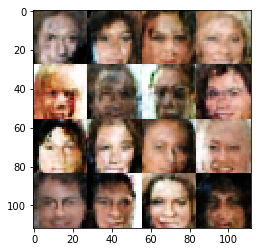

Step: 1520, Epoch: 1/1... Discriminator Loss: 1.5975 Generator Loss: 0.9317
Step: 1540, Epoch: 1/1... Discriminator Loss: 1.4207 Generator Loss: 0.9132
Step: 1560, Epoch: 1/1... Discriminator Loss: 1.5430 Generator Loss: 1.0389
Step: 1580, Epoch: 1/1... Discriminator Loss: 1.4559 Generator Loss: 0.7186
Step: 1600, Epoch: 1/1... Discriminator Loss: 1.4591 Generator Loss: 1.1476


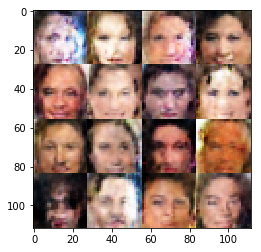

Step: 1620, Epoch: 1/1... Discriminator Loss: 1.4338 Generator Loss: 0.8797
Step: 1640, Epoch: 1/1... Discriminator Loss: 1.4554 Generator Loss: 0.8632
Step: 1660, Epoch: 1/1... Discriminator Loss: 1.5190 Generator Loss: 0.9020
Step: 1680, Epoch: 1/1... Discriminator Loss: 1.5611 Generator Loss: 0.7845
Step: 1700, Epoch: 1/1... Discriminator Loss: 1.4655 Generator Loss: 0.9932


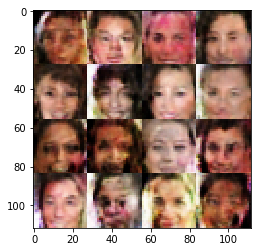

Step: 1720, Epoch: 1/1... Discriminator Loss: 1.4400 Generator Loss: 0.6976
Step: 1740, Epoch: 1/1... Discriminator Loss: 1.4506 Generator Loss: 0.8828
Step: 1760, Epoch: 1/1... Discriminator Loss: 1.3851 Generator Loss: 0.8087
Step: 1780, Epoch: 1/1... Discriminator Loss: 1.3367 Generator Loss: 0.9088
Step: 1800, Epoch: 1/1... Discriminator Loss: 1.4724 Generator Loss: 0.9442


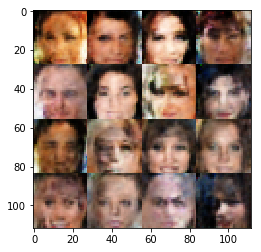

Step: 1820, Epoch: 1/1... Discriminator Loss: 1.4329 Generator Loss: 0.8057
Step: 1840, Epoch: 1/1... Discriminator Loss: 1.4366 Generator Loss: 0.8167
Step: 1860, Epoch: 1/1... Discriminator Loss: 1.4538 Generator Loss: 0.9040
Step: 1880, Epoch: 1/1... Discriminator Loss: 1.4417 Generator Loss: 0.7326
Step: 1900, Epoch: 1/1... Discriminator Loss: 1.4612 Generator Loss: 0.8225


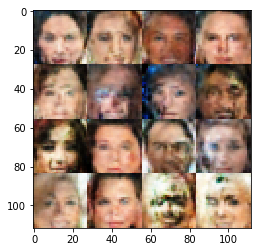

Step: 1920, Epoch: 1/1... Discriminator Loss: 1.4527 Generator Loss: 0.9261
Step: 1940, Epoch: 1/1... Discriminator Loss: 1.4898 Generator Loss: 1.1328
Step: 1960, Epoch: 1/1... Discriminator Loss: 1.4360 Generator Loss: 0.7315
Step: 1980, Epoch: 1/1... Discriminator Loss: 1.4445 Generator Loss: 0.8707
Step: 2000, Epoch: 1/1... Discriminator Loss: 1.4355 Generator Loss: 0.9169


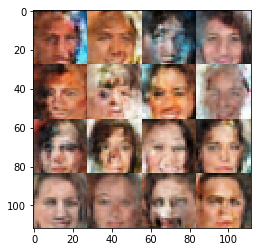

Step: 2020, Epoch: 1/1... Discriminator Loss: 1.4246 Generator Loss: 0.8273
Step: 2040, Epoch: 1/1... Discriminator Loss: 1.4558 Generator Loss: 0.8225
Step: 2060, Epoch: 1/1... Discriminator Loss: 1.4117 Generator Loss: 0.9580
Step: 2080, Epoch: 1/1... Discriminator Loss: 1.4979 Generator Loss: 0.7146
Step: 2100, Epoch: 1/1... Discriminator Loss: 1.4573 Generator Loss: 0.9363


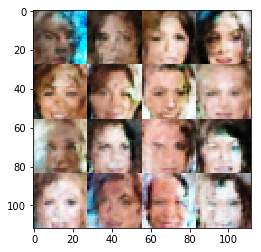

Step: 2120, Epoch: 1/1... Discriminator Loss: 1.4257 Generator Loss: 0.8044
Step: 2140, Epoch: 1/1... Discriminator Loss: 1.4235 Generator Loss: 0.8337
Step: 2160, Epoch: 1/1... Discriminator Loss: 1.4109 Generator Loss: 0.8217
Step: 2180, Epoch: 1/1... Discriminator Loss: 1.4681 Generator Loss: 0.8362
Step: 2200, Epoch: 1/1... Discriminator Loss: 1.3994 Generator Loss: 0.8744


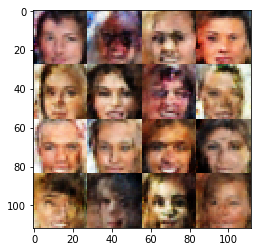

Step: 2220, Epoch: 1/1... Discriminator Loss: 1.3800 Generator Loss: 0.6753
Step: 2240, Epoch: 1/1... Discriminator Loss: 1.4212 Generator Loss: 0.8749
Step: 2260, Epoch: 1/1... Discriminator Loss: 1.4324 Generator Loss: 1.0394
Step: 2280, Epoch: 1/1... Discriminator Loss: 1.5057 Generator Loss: 1.1174
Step: 2300, Epoch: 1/1... Discriminator Loss: 1.3991 Generator Loss: 0.7676


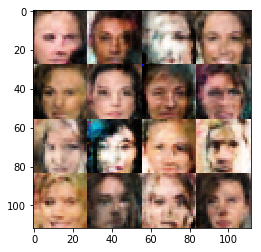

Step: 2320, Epoch: 1/1... Discriminator Loss: 1.4285 Generator Loss: 0.8324
Step: 2340, Epoch: 1/1... Discriminator Loss: 1.4455 Generator Loss: 0.7679
Step: 2360, Epoch: 1/1... Discriminator Loss: 1.4161 Generator Loss: 0.7342
Step: 2380, Epoch: 1/1... Discriminator Loss: 1.4114 Generator Loss: 0.8971
Step: 2400, Epoch: 1/1... Discriminator Loss: 1.4206 Generator Loss: 0.8755


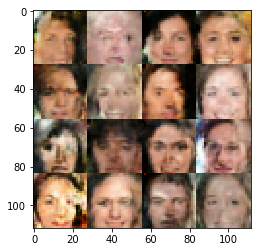

Step: 2420, Epoch: 1/1... Discriminator Loss: 1.4025 Generator Loss: 1.0021
Step: 2440, Epoch: 1/1... Discriminator Loss: 1.4020 Generator Loss: 0.7338
Step: 2460, Epoch: 1/1... Discriminator Loss: 1.3795 Generator Loss: 0.9024
Step: 2480, Epoch: 1/1... Discriminator Loss: 1.4114 Generator Loss: 0.8511
Step: 2500, Epoch: 1/1... Discriminator Loss: 1.4763 Generator Loss: 0.8827


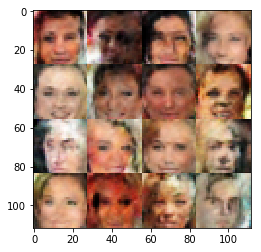

Step: 2520, Epoch: 1/1... Discriminator Loss: 1.4382 Generator Loss: 0.7638
Step: 2540, Epoch: 1/1... Discriminator Loss: 1.3528 Generator Loss: 0.8572
Step: 2560, Epoch: 1/1... Discriminator Loss: 1.4210 Generator Loss: 0.6790
Step: 2580, Epoch: 1/1... Discriminator Loss: 1.4321 Generator Loss: 0.8644
Step: 2600, Epoch: 1/1... Discriminator Loss: 1.4417 Generator Loss: 0.9029


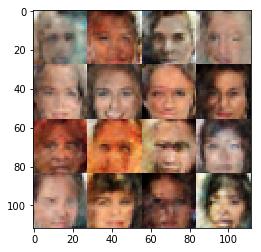

Step: 2620, Epoch: 1/1... Discriminator Loss: 1.4138 Generator Loss: 0.9479
Step: 2640, Epoch: 1/1... Discriminator Loss: 1.3893 Generator Loss: 0.8159
Step: 2660, Epoch: 1/1... Discriminator Loss: 1.3725 Generator Loss: 0.6793
Step: 2680, Epoch: 1/1... Discriminator Loss: 1.5140 Generator Loss: 1.1112
Step: 2700, Epoch: 1/1... Discriminator Loss: 1.4247 Generator Loss: 0.8428


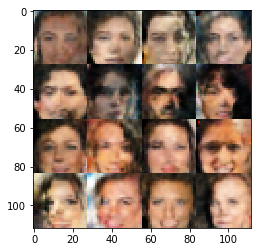

Step: 2720, Epoch: 1/1... Discriminator Loss: 1.3990 Generator Loss: 0.9867
Step: 2740, Epoch: 1/1... Discriminator Loss: 1.3906 Generator Loss: 0.9087
Step: 2760, Epoch: 1/1... Discriminator Loss: 1.3980 Generator Loss: 0.9035
Step: 2780, Epoch: 1/1... Discriminator Loss: 1.4178 Generator Loss: 0.9249
Step: 2800, Epoch: 1/1... Discriminator Loss: 1.3838 Generator Loss: 0.8892


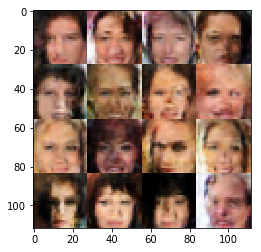

Step: 2820, Epoch: 1/1... Discriminator Loss: 1.4305 Generator Loss: 0.8008
Step: 2840, Epoch: 1/1... Discriminator Loss: 1.4307 Generator Loss: 0.8966
Step: 2860, Epoch: 1/1... Discriminator Loss: 1.4097 Generator Loss: 0.8677
Step: 2880, Epoch: 1/1... Discriminator Loss: 1.4022 Generator Loss: 0.7906
Step: 2900, Epoch: 1/1... Discriminator Loss: 1.4389 Generator Loss: 0.8574


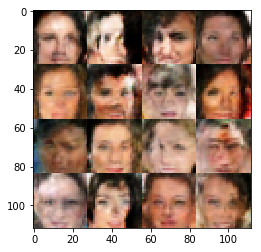

Step: 2920, Epoch: 1/1... Discriminator Loss: 1.4324 Generator Loss: 0.7402
Step: 2940, Epoch: 1/1... Discriminator Loss: 1.4564 Generator Loss: 0.7360
Step: 2960, Epoch: 1/1... Discriminator Loss: 1.4193 Generator Loss: 0.8457
Step: 2980, Epoch: 1/1... Discriminator Loss: 1.4213 Generator Loss: 0.8010
Step: 3000, Epoch: 1/1... Discriminator Loss: 1.3682 Generator Loss: 0.9327


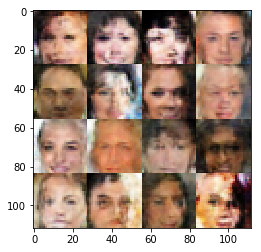

Step: 3020, Epoch: 1/1... Discriminator Loss: 1.4012 Generator Loss: 0.8007
Step: 3040, Epoch: 1/1... Discriminator Loss: 1.3966 Generator Loss: 0.8219
Step: 3060, Epoch: 1/1... Discriminator Loss: 1.4274 Generator Loss: 0.8022
Step: 3080, Epoch: 1/1... Discriminator Loss: 1.4435 Generator Loss: 0.7453
Step: 3100, Epoch: 1/1... Discriminator Loss: 1.3455 Generator Loss: 0.8088


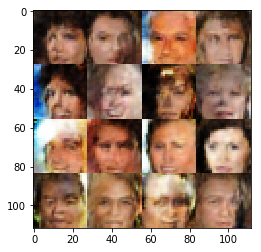

Step: 3120, Epoch: 1/1... Discriminator Loss: 1.4294 Generator Loss: 0.8646
Step: 3140, Epoch: 1/1... Discriminator Loss: 1.4077 Generator Loss: 0.7266
Step: 3160, Epoch: 1/1... Discriminator Loss: 1.3869 Generator Loss: 0.8306


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.